In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install sentencepiece
!pip install nlpaug
!pip install transformers
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
!pip install torch
!pip install transformers

import nlpaug.augmenter.word as naw
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import  BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from transformers import AdamW

In [ ]:


# Step 1: Prepare the data
data = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/BALANCED_DATA/balanced_data.csv')
data = data.dropna()
X = data['description']
y = data['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fine-tune the XLNet model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['label'].unique()))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')
# Convert the input data to tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                             torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

# Define batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20


train_accuracy_list = []
train_loss_list = []
test_loss_list = []
test_accuracy_list  = []
epoch_list = []

tokenizer.save_pretrained('/content/drive/MyDrive/NLP_PROJECT/BERT_TOKENIZER')


for epoch in range(num_epochs):
    epoch_list.append(epoch+1)
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
    # After training loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0



    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, predicted_labels = torch.max(logits, 1)
            test_correct += (predicted_labels == labels).sum().item()
            test_total += labels.size(0)

            test_loss += loss.item()

    test_accuracy = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

    # Save the model weights and optimizer state dictionary
    model_path = f'/content/drive/MyDrive/NLP_PROJECT/BERT_WEIGHTS/model_epoch_{epoch + 1}.pt'
    torch.save(model.state_dict(), model_path)



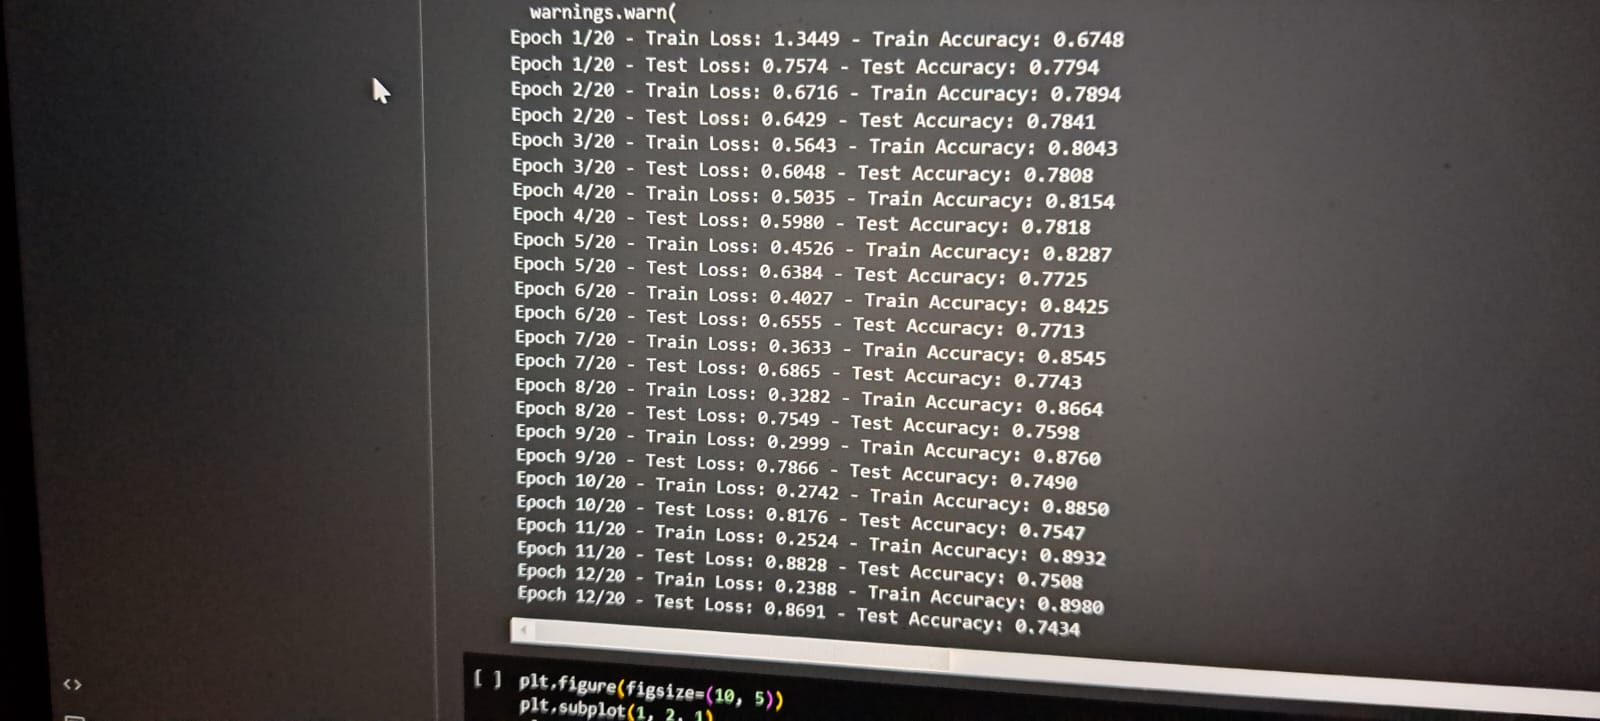

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the plots to a specific directory
plots_dir = '/content/drive/MyDrive/NLP_PROJECT/PLOTS'
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, 'bert_loss_and_accuracy_curves.png'))
plt.show()